## Sample code

Borrowed codes are the same as the ones in EDA.ipynb file

### Installing the library

This code is borrowed below

In [1]:
from itertools import cycle
import re

import warnings
import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,auc,log_loss,roc_curve,roc_auc_score



In [2]:
#Setting up the notebook’s plots
warnings.filterwarnings("ignore")
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])



### Loading the learning data

This code is borrowed

In [19]:
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

df = pd.concat([train_df,test_df])
print(train_df.shape,test_df.shape)

df['arrival_date'] = pd.to_datetime(df['arrival_date'])

(108785, 27) (10099, 26)


### Preprocessing

This code below is original

In [20]:
train_df = train_df[(train_df.adr > 0) &(train_df.adr < 1000)&(train_df.required_car_parking_spaces < 5)]

In [21]:
train_df["eval"] = (train_df.adults == 0) & ((train_df.children > 0)|(train_df.babies > 0)) | (train_df.required_car_parking_spaces > 0)

In [22]:
train_df["eval"] = train_df["eval"].astype(str)

In [23]:
train_df = train_df[train_df["eval"] == "False"]

In [24]:
train_df["country"].value_counts()

PRT    41682
GBR    10157
FRA     8909
ESP     6448
DEU     6108
       ...  
VGB        1
KIR        1
NCL        1
DMA        1
MYT        1
Name: country, Length: 172, dtype: int64

In [33]:
num_features = ["lead_time",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "previous_cancellations","previous_bookings_not_canceled",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","meal","market_segment",
                "distribution_channel","reserved_room_type","assigned_room_type","customer_type"]

features = num_features + cat_features

#### These code below is borrowed

In [34]:
#Convert the category variables into numerals
le = LabelEncoder()
le_dict = {}
for col in cat_features:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    le_dict['col']=le

#Convert into category-types
train_df[cat_features] = train_df[cat_features].astype('category')
test_df[cat_features] = test_df[cat_features].astype('category')

In [35]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_df_new = train_df.iloc[:80000,:]
valid_df = train_df.iloc[80000:,:]

In [36]:
#Separate the explanatory variables and objective variables
train_y = train_df_new["is_canceled"]
train_X = train_df_new.drop(["is_canceled",'arrival_date'], axis=1)[features]

test_X = valid_df.drop(['arrival_date','is_canceled'], axis=1)[features]
test_Y = valid_df['is_canceled']

In [37]:
# Convert dataframe into numpy.array
train_X_arr = train_X.values
test_X_arr = test_X.values

In [13]:
#Define the model
clf = RandomForestClassifier()

In [14]:
# from sklearn.ensemble import AdaBoostClassifier
# clf = AdaBoostClassifier() -- 0.9337

In [15]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier() -- 0.939

## Learning

Conduct a 4-fold cross-validation.

In [16]:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
oof = np.zeros((len(train_X_arr),))
preds =np.zeros((len(test_X_arr),))

for i,(train_idx, val_idx) in enumerate(split.split(train_X_arr, train_y)):
    print(i,end='')
    clf = RandomForestClassifier()
    clf_train = clf.fit(train_X_arr[train_idx,:], train_y[train_idx])
    
    #Obtain the predicted values of the validation data
    oof[val_idx] = clf.predict_proba(train_X_arr[val_idx,:])[:,1]
    #Obtain the predicted values of the test data
    preds += clf.predict_proba(test_X_arr)[:,1]/ split.n_splits


0123

### Precision check using the results produced from the cross-validation

In [17]:
pred_train_df = train_df.copy()
pred_train_df['preds'] = oof

log_loss: 0.3530318103456611
auc score: 0.9337817323423345


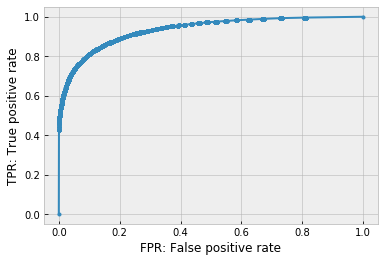

In [18]:
#Create a ROC curve using the validation data
fpr, tpr, thresholds = roc_curve(pred_train_df['is_canceled'],pred_train_df['preds'])
plt.grid(b=True, which='major', linestyle='-')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.plot()
print('log_loss:',log_loss(pred_train_df['is_canceled'],pred_train_df['preds']))
print('auc score:',roc_auc_score(pred_train_df['is_canceled'],pred_train_df['preds']))

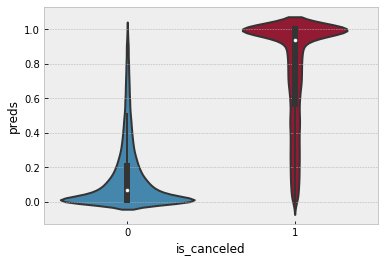

In [19]:
#　Confirm the distribution of predictions
sns.violinplot(pred_train_df['is_canceled'],pred_train_df['preds'])

#### These code below is original

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skens

In [61]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators':[1000,1500],
              'max_depth':[200,300],
              'max_features':[9]
             }

rf = RandomForestClassifier(random_state = 0,n_jobs = -1)
clf_rf = GridSearchCV(rf, parameters,cv=4,scoring='roc_auc')
clf_rf.fit(train_X, train_y)
print('RandomForest best score:',clf_rf.best_score_) 
print('RandomForest best params',clf_rf.best_params_) 


RandomForest best score: 0.9171281161057911
RandomForest best params {'max_depth': 200, 'max_features': 9, 'n_estimators': 1000}


In [40]:
rf_best = RandomForestClassifier(random_state = 0,n_jobs = -1,max_features = 9, max_depth = 200,n_estimators = 1000)
rf_best.fit(train_X,train_y)

RandomForestClassifier(max_depth=200, max_features=9, n_estimators=1000,
                       n_jobs=-1, random_state=0)

In [62]:
predict_Y = rf_best.predict(test_X)
roc_auc_score(test_Y,predict_Y)

0.8426281574768394

## Feature Importance

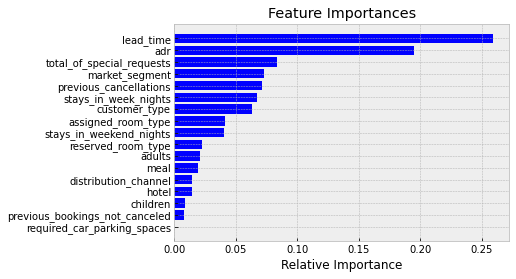

In [41]:
import matplotlib.pyplot as plt

features = train_X.columns
importances = rf_best.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Creating the code for submission

In [14]:
#Load the predicted values onto the dataframe for submission
submission = test_df.copy()
preds = 
submission['preds'] = preds

NameError: name 'preds' is not defined

In [21]:
submission[['id','preds']].to_csv('submission.csv')